# Importing packages

In [52]:
import numpy as np
import pandas as pd
import os
import dask
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interpn

from scipy.interpolate import griddata

# retina
%config InlineBackend.figure_format = 'retina'

# Load reference simulation

In [6]:
sp_path = "/Users/jerrylin/Desktop/OfflineWork/data/spcamTrim/"
sp_list = os.popen(" ".join(["ls", sp_path + "*.h1.*"])).read().splitlines()
sp_output = xr.open_mfdataset(sp_list)
sptbp = sp_output["NNTBP"][::48,:,:,:]
spqbp = sp_output["NNQBP"][::48,:,:,:]
spps = sp_output["NNPS"][::48,:,:]
sp_lon = sp_output["lon"]
sp_lat = sp_output["lat"]
sp_lev = sp_output["lev"]
sp_hyam = sp_output["hyam"][::48,:]
sp_hybm = sp_output["hybm"][::48,:]

sp_pg = sp_hyam*1e5 + spps*sp_hybm
log_sp_pg = np.log(sp_pg.values)

Y_pres = sp_pg.mean(dim = ["time", "lon"]).values

sptbp_mean = sptbp.mean(dim = ["lon", "time"])
spqbp_mean = spqbp.mean(dim = ["lon", "time"])

sptbp_max = sptbp.max().values
sptbp_min = sptbp.min().values
spqbp_max = spqbp.max().values
spqbp_min = spqbp.min().values

month_length = np.array([len(sp_output.groupby("time.month")[x]["time"]) for x in np.array(range(12))+1])
month_sum = np.cumsum(month_length)
month_sum_start = np.insert(month_sum, 0, 0)[:-1]
month_start_stop = [(month_sum_start[i],month_sum[i]) for i in range(12)]

# Define paths for NN runs

In [7]:
new_path = "/Users/jerrylin/Desktop/OfflineWork/data/new_runs/"

relative_new = [new_path + "relative/" + "relative_model_063/", \
                new_path + "relative/" + "relative_model_081/", \
                new_path + "relative/" + "relative_model_095/", \
                new_path + "relative/" + "relative_model_096/", \
                new_path + "relative/" + "relative_model_138/"]
expanded_new = [new_path + "expanded/" + "expanded_model_012/", \
                new_path + "expanded/" + "expanded_model_024/", \
                new_path + "expanded/" + "expanded_model_091/", \
                new_path + "expanded/" + "expanded_model_099/", \
                new_path + "expanded/" + "expanded_model_108/"]
previous_new = [new_path + "previous/" + "previousTendencies_model_059/", \
                new_path + "previous/" + "previousTendencies_model_072/", \
                new_path + "previous/" + "previousTendencies_model_112/", \
                new_path + "previous/" + "previousTendencies_model_173/", \
                new_path + "previous/" + "previousTendencies_model_193/"]

# Create plotting functions

In [8]:
def plot_ps(nn_path):
    nn_list = os.popen(" ".join(["ls", nn_path + "*.h1.*"])).read().splitlines()
    nn_output = xr.open_mfdataset(nn_list)
    nnps = nn_output["NNPS"][0:365,:,::16]
    fig1 = plt.figure(figsize=(12,6))
    myfontsize = 12
    ax1 = fig1.add_subplot(1,2,1) # (rows, cols, plots)
    ax1.hist(nnps.values.flatten(), bins = 100)
    ax1.legend(frameon = False, fontsize = myfontsize)
    ax1.set_xlabel("surface pressure", fontsize = myfontsize)
    ax1.set_ylabel("Frequency", fontsize = myfontsize)
    ax1.set_title("NN simulation", fontsize = myfontsize)

    ax2 = fig1.add_subplot(1,2,2)
    ax2.hist(spps.values.flatten(), bins = 100)
    ax2.legend(frameon = False, fontsize = myfontsize)
    ax2.set_xlabel("surface pressure", fontsize = myfontsize)
    ax2.set_ylabel("Frequency", fontsize = myfontsize)
    ax2.set_title("SP simulation", fontsize = myfontsize)
    fig1.suptitle('Comparing histograms of NN and SP surface pressures', fontsize = myfontsize + 2)
    return

def plot_diffps(nn_path):
    nn_list = os.popen(" ".join(["ls", nn_path + "*.h1.*"])).read().splitlines()
    nn_output = xr.open_mfdataset(nn_list)
    nnps = nn_output["NNPS"][0:365,:,::16]
    diffs = nnps - spps
    fig1 = plt.figure(figsize=(12,6))
    myfontsize = 12
    ax1 = fig1.add_subplot(1,2,1) # (rows, cols, plots)
    ax1.hist(diffs.values.flatten(), bins = 100)
    ax1.legend(frameon = False, fontsize = myfontsize)
    ax1.set_xlabel("difference in surface pressure", fontsize = myfontsize)
    ax1.set_ylabel("Frequency", fontsize = myfontsize)
    ax1.set_title("NN - SP surface pressure", fontsize = myfontsize)
    return

def pressure_grid(nn_path):
    nn_list = os.popen(" ".join(["ls", nn_path + "*.h1.*"])).read().splitlines()
    nn_output = xr.open_mfdataset(nn_list)
    nnps = nn_output["NNPS"][0:365,:,::16]
    nn_hyam = nn_output["hyam"][0:365,::16,:]
    nn_hybm = nn_output["hybm"][0:365,::16,:]
    for i in range(7):
        assert(0==np.sum(nn_hyam[:,0,:].values-nn_hyam[:,i+1,:].values))
        assert(0==np.sum(nn_hybm[:,0,:].values-nn_hybm[:,i+1,:].values))
    nn_hyam = nn_hyam[:,0,:]
    nn_hybm = nn_hybm[:,0,:]
    assert nnps.shape == spps.shape
    assert nn_hyam.shape == sp_hyam.shape
    assert nn_hybm.shape == sp_hybm.shape
    nn_pressure_grid = nn_hyam * 1e5 + nnps * nn_hybm
    assert nn_pressure_grid.shape == sp_pg.shape
    return nn_pressure_grid

def get_nntbp_diff(nn_path):
    nn_list = os.popen(" ".join(["ls", nn_path + "*.h1.*"])).read().splitlines()
    nn_output = xr.open_mfdataset(nn_list)
    assert nn_output["NNTBP"].shape[3] == 128
    nntbp = nn_output["NNTBP"][0:365,:,:,::16].values
    nntbp_diff = np.mean(nntbp - sptbp.values, axis = (0,3))
    return nntbp_diff

In [9]:
rel_diffs = [get_nntbp_diff(x) for x in relative_new]
exp_diffs = [get_nntbp_diff(x) for x in expanded_new]
prev_diffs = [get_nntbp_diff(x) for x in previous_new]

In [23]:
np.sin(sp_lat*np.pi/180)

<xarray.DataArray 'lat' (lat: 64)>
array([-0.99930504, -0.99634012, -0.99101337, -0.98333625, -0.97332683,
       -0.9610088 , -0.94641137, -0.92956917, -0.91052214, -0.88931545,
       -0.8659994 , -0.8406293 , -0.81326532, -0.78397236, -0.75281991,
       -0.71988185, -0.68523631, -0.64896547, -0.61115536, -0.57189565,
       -0.53127946, -0.48940315, -0.44636602, -0.40227016, -0.35722016,
       -0.31132287, -0.26468716, -0.21742364, -0.16964442, -0.12146282,
       -0.07299312, -0.02435029,  0.02435029,  0.07299312,  0.12146282,
        0.16964442,  0.21742364,  0.26468716,  0.31132287,  0.35722016,
        0.40227016,  0.44636602,  0.48940315,  0.53127946,  0.57189565,
        0.61115536,  0.64896547,  0.68523631,  0.71988185,  0.75281991,
        0.78397236,  0.81326532,  0.8406293 ,  0.8659994 ,  0.88931545,
        0.91052214,  0.92956917,  0.94641137,  0.9610088 ,  0.97332683,
        0.98333625,  0.99101337,  0.99634012,  0.99930504])
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86

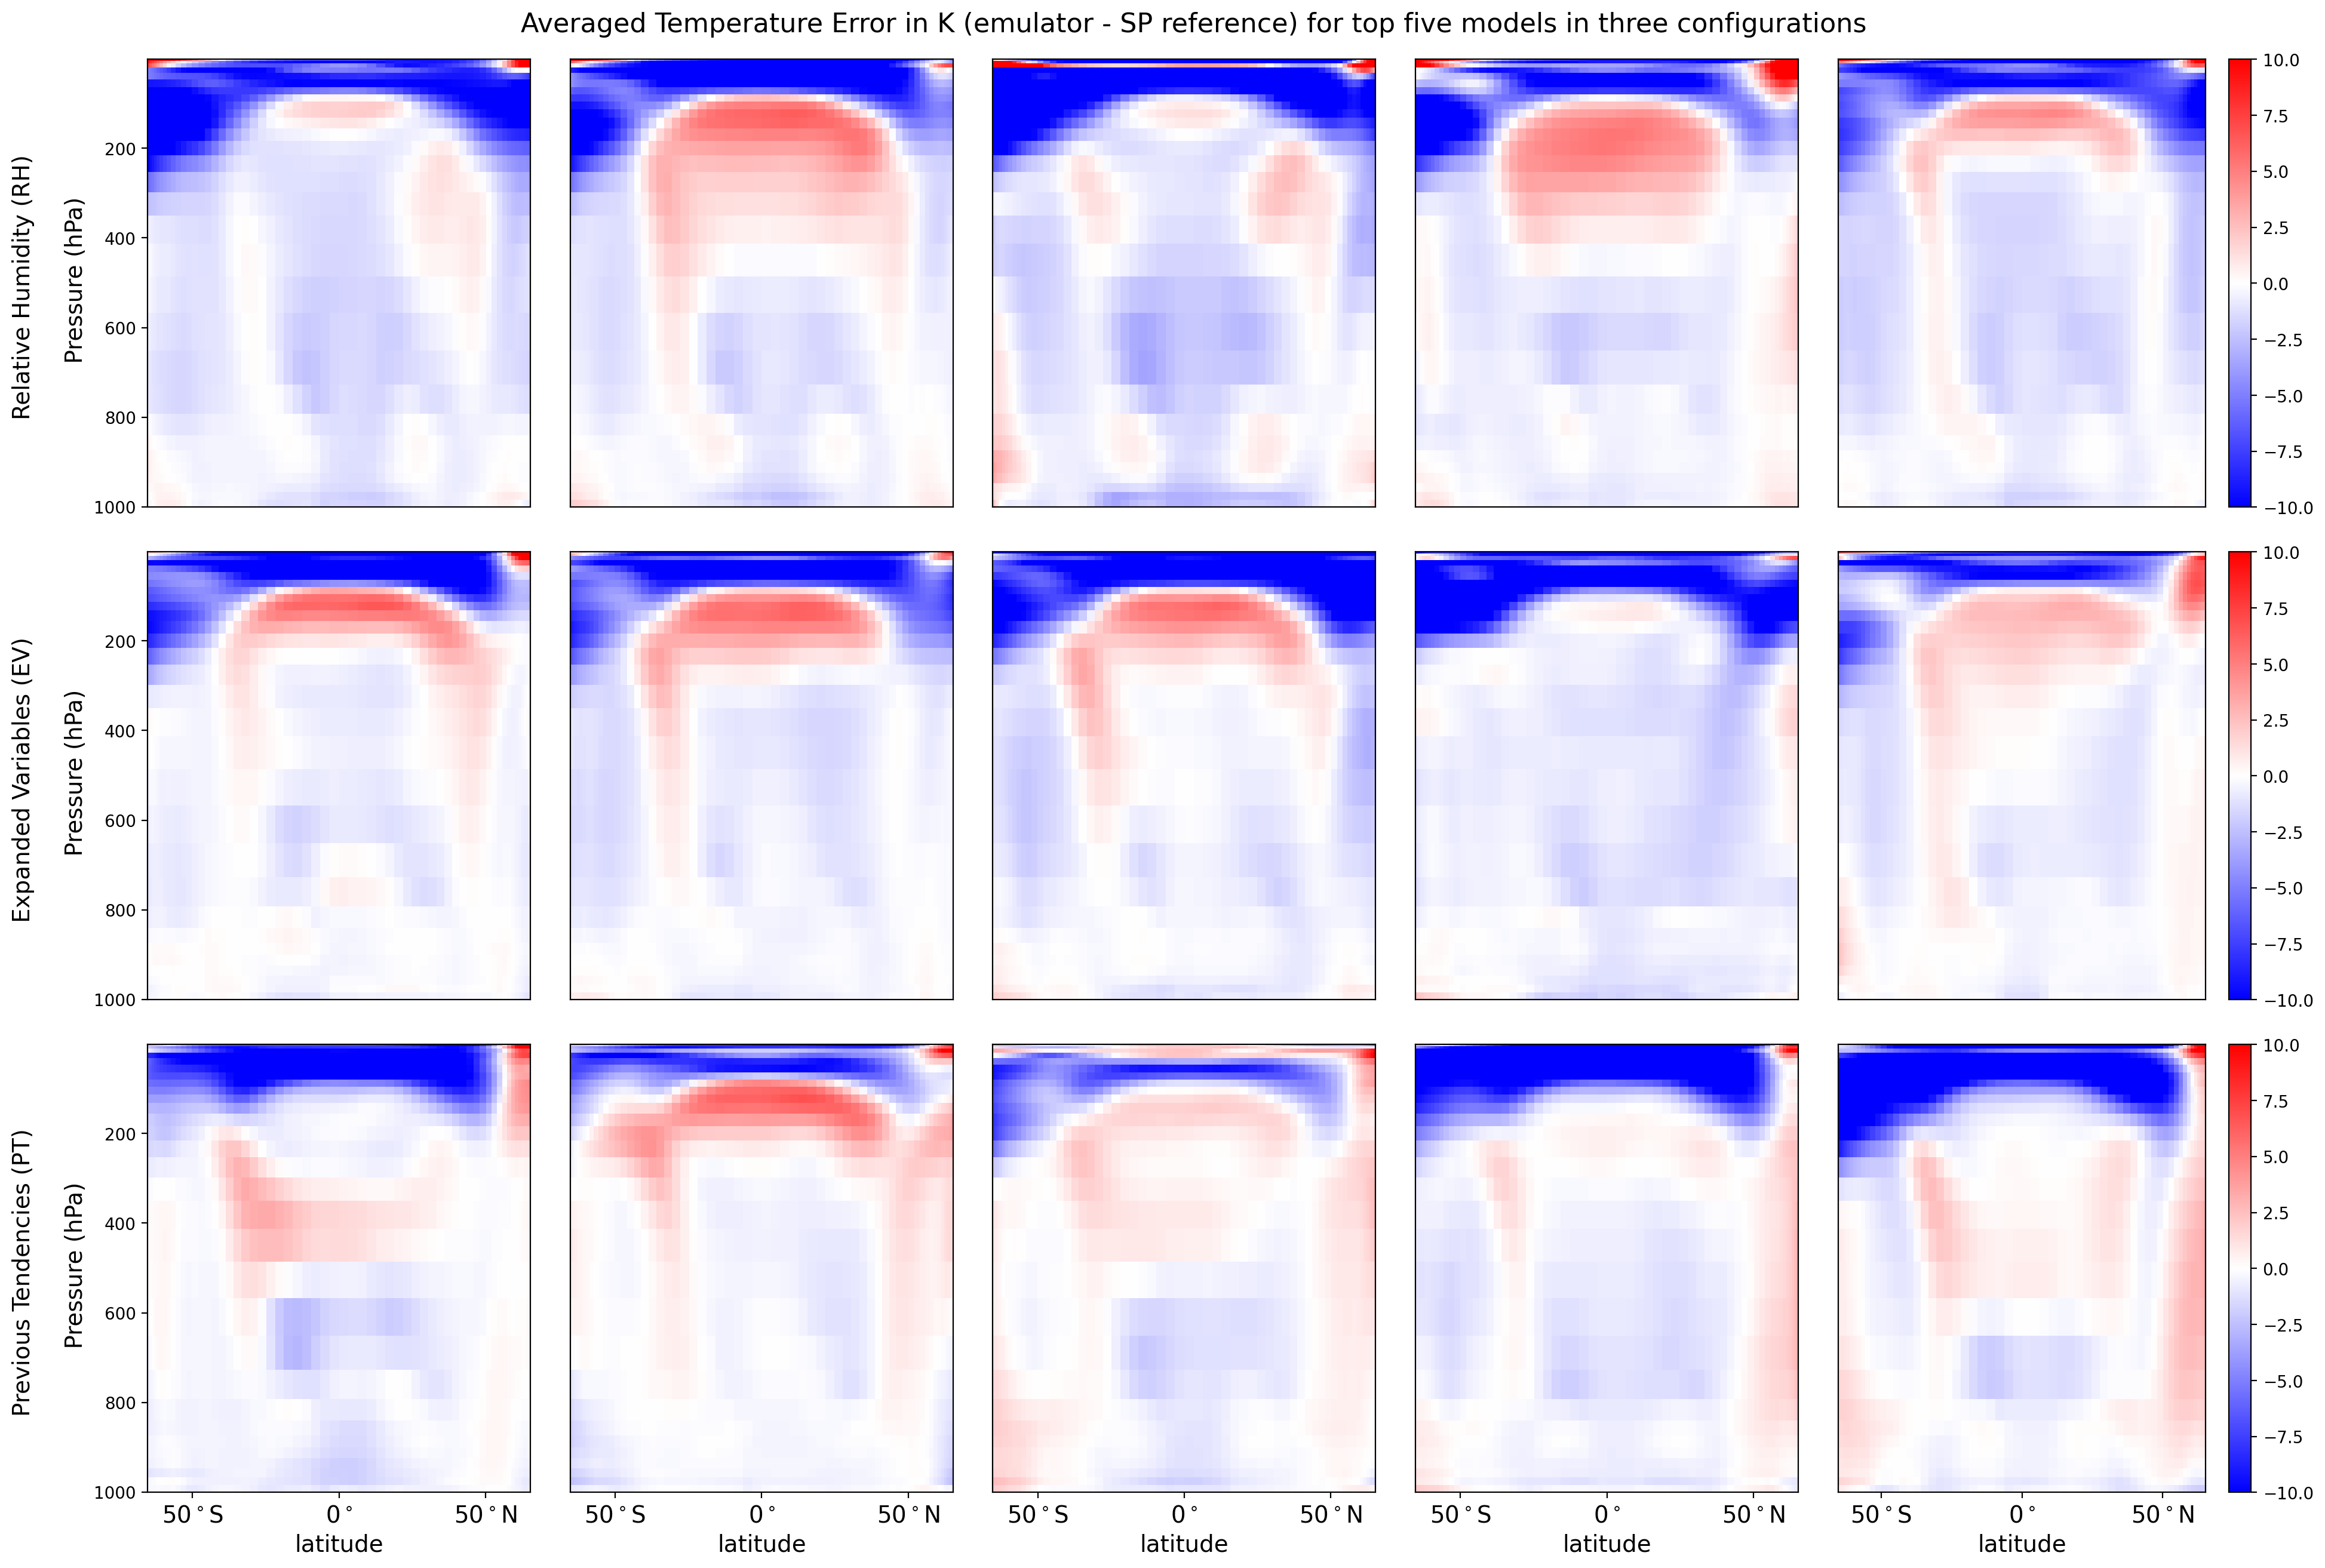

In [54]:
def peer(rel_diffs, exp_diffs, prev_diffs, vmin, vmax):
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 8),
                         gridspec_kw={'width_ratios': [1, 1, 1, 1, 1.2]})
    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[0,2]
    ax4 = ax[0,3]
    ax5 = ax[0,4]

    ax6 = ax[1,0]
    ax7 = ax[1,1]
    ax8 = ax[1,2]
    ax9 = ax[1,3]
    ax10 = ax[1,4]

    ax11 = ax[2,0]
    ax12 = ax[2,1]
    ax13 = ax[2,2]
    ax14 = ax[2,3]
    ax15 = ax[2,4]

    X, Y = np.meshgrid(np.sin(sp_lat*np.pi/180), sp_lev)

    pcm1 = ax1.pcolormesh(X, Y, rel_diffs[0], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax1.set_xticks([])
    ax1.set_ylabel("Relative Humidity (RH) \n \n Pressure (hPa)", fontsize = 14)
    ax1.set_ylim(ax1.get_ylim()[::-1])
    
    pcm2 = ax2.pcolormesh(X, Y, rel_diffs[1], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim(ax2.get_ylim()[::-1])

    pcm3 = ax3.pcolormesh(X, Y, rel_diffs[2], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_ylim(ax3.get_ylim()[::-1])

    pcm4 = ax4.pcolormesh(X, Y, rel_diffs[3], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_ylim(ax4.get_ylim()[::-1])

    pcm5 = ax5.pcolormesh(X, Y, rel_diffs[4], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax5.set_xticks([])
    ax5.set_yticks([])
    fig.colorbar(pcm5, ax = ax5)
    ax5.set_ylim(ax5.get_ylim()[::-1])

    pcm6 = ax6.pcolormesh(X, Y, exp_diffs[0], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax6.set_xticks([])
    ax6.set_ylabel("Expanded Variables (EV) \n \n Pressure (hPa)", fontsize = 14)
    ax6.set_ylim(ax6.get_ylim()[::-1])

    pcm7 = ax7.pcolormesh(X, Y, exp_diffs[1], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax7.set_ylim(ax7.get_ylim()[::-1])

    pcm8 = ax8.pcolormesh(X, Y, exp_diffs[2], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax8.set_ylim(ax8.get_ylim()[::-1])

    pcm9 = ax9.pcolormesh(X, Y, exp_diffs[3], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax9.set_xticks([])
    ax9.set_yticks([])
    ax9.set_ylim(ax9.get_ylim()[::-1])

    pcm10 = ax10.pcolormesh(X, Y, exp_diffs[4], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax10.set_xticks([])
    ax10.set_yticks([])
    fig.colorbar(pcm10, ax = ax10)
    ax10.set_ylim(ax10.get_ylim()[::-1])

    pcm11 = ax11.pcolormesh(X, Y, prev_diffs[0], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax11.set_xlabel("latitude", fontsize = 14)
    ax11.xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax11.xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 14)
    ax11.set_ylabel("Previous Tendencies (PT) \n \n Pressure (hPa)", fontsize = 14)
    ax11.set_ylim(ax11.get_ylim()[::-1])

    pcm12 = ax12.pcolormesh(X, Y, prev_diffs[1], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax12.set_yticks([])
    ax12.set_xlabel("latitude", fontsize = 14)
    ax12.xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax12.xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 14)
    ax12.set_ylim(ax12.get_ylim()[::-1])

    pcm13 = ax13.pcolormesh(X, Y, prev_diffs[2], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax13.set_yticks([])
    ax13.set_xlabel("latitude", fontsize = 14)
    ax13.xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax13.xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 14)
    ax13.set_ylim(ax13.get_ylim()[::-1])

    pcm14 = ax14.pcolormesh(X, Y, prev_diffs[3], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax14.set_yticks([])
    ax14.set_xlabel("latitude", fontsize = 14)
    ax14.xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax14.xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 14)
    ax14.set_ylim(ax14.get_ylim()[::-1])

    pcm15 = ax15.pcolormesh(X, Y, prev_diffs[4], cmap = "bwr", vmin = vmin, vmax = vmax)
    ax15.set_yticks([])
    fig.colorbar(pcm15, ax = ax15)
    ax15.set_xlabel("latitude", fontsize = 14)
    ax15.xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax15.xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 14)
    ax15.set_ylim(ax15.get_ylim()[::-1])

    fig.suptitle(t = "Averaged Temperature Error in K (emulator - SP reference) for top five models in three configurations", \
                 x = .73, y = 1.55, fontsize = 16)
    plt.subplots_adjust(hspace=0.1, wspace=.1)
    plt.subplots_adjust(0,0,1.5,1.5)
    return

peer(rel_diffs, exp_diffs, prev_diffs, vmin = -10, vmax = 10)

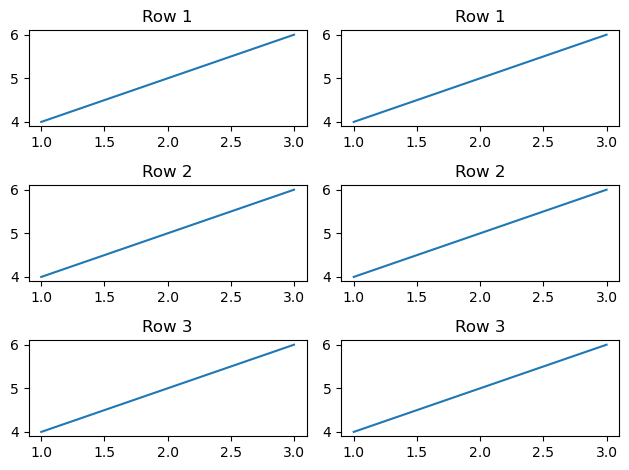

In [78]:
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2)

# Set the titles for each row
row_titles = ['Row 1', 'Row 2', 'Row 3']
for i, ax_row in enumerate(axs):
    for ax in ax_row:
        ax.set_title(row_titles[i])

# Add content to the subplots (for illustration purposes)
for ax_row in axs:
    for ax in ax_row:
        ax.plot([1, 2, 3], [4, 5, 6])

# Display the plot
plt.tight_layout()  # Ensures proper spacing and alignment
plt.show()

### relative

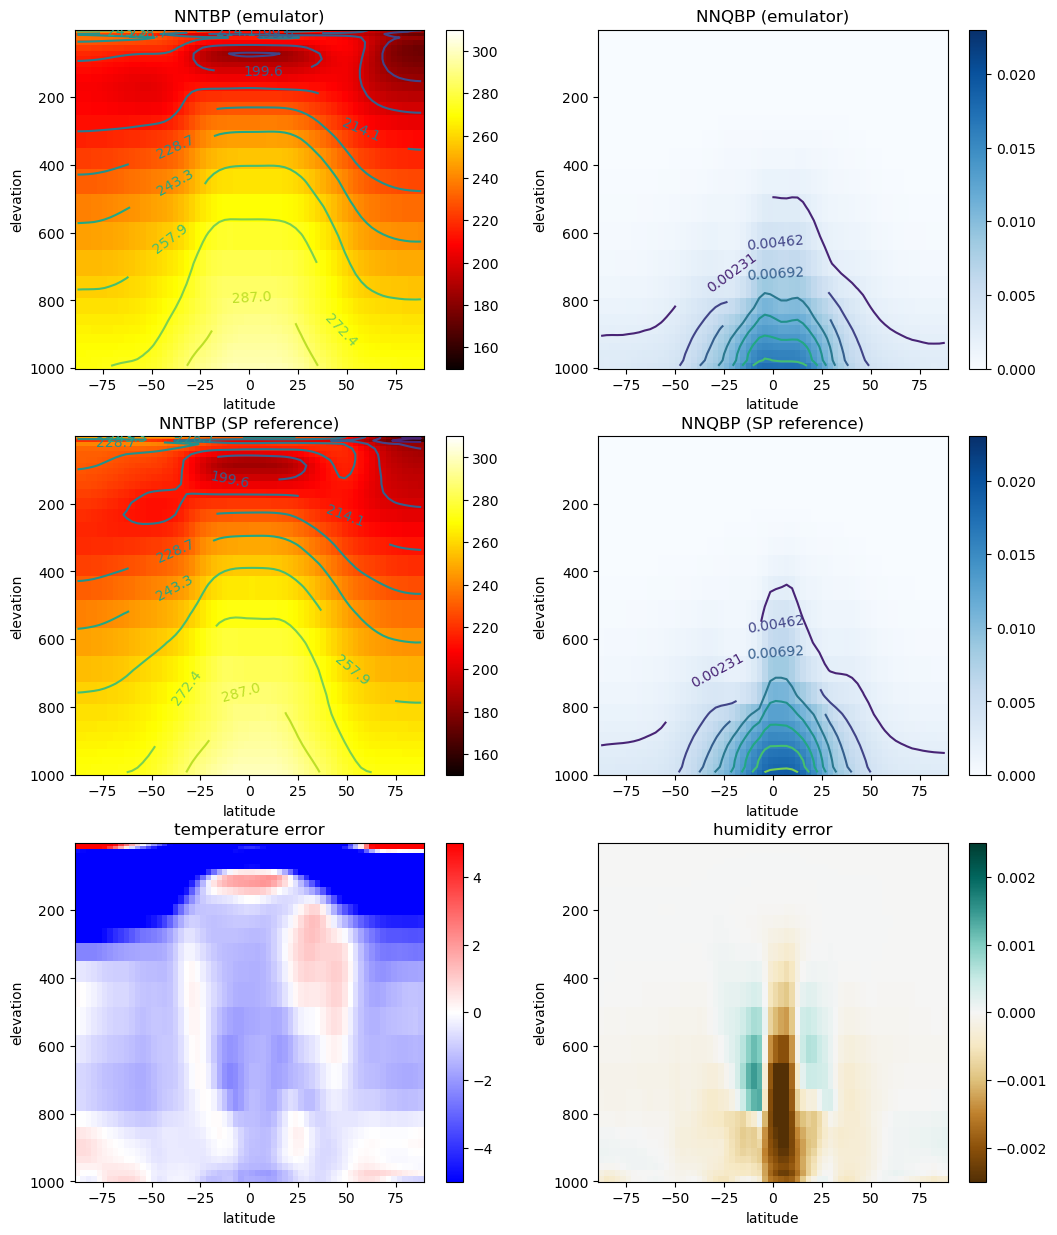

In [303]:
peer(relative_new[0], variant = "original")

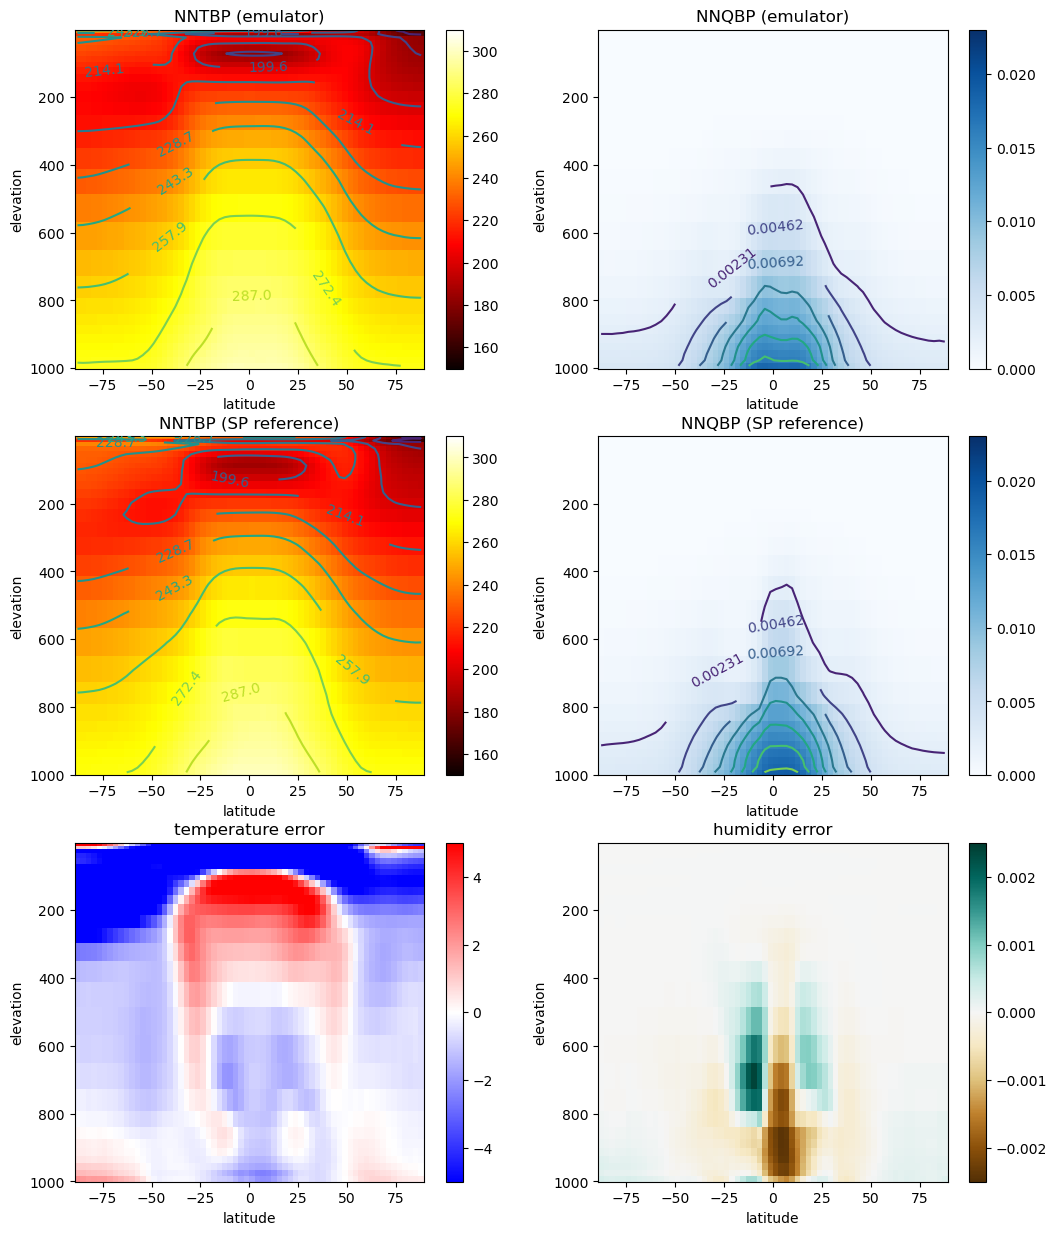

In [307]:
peer(relative_new[1], variant = "original")

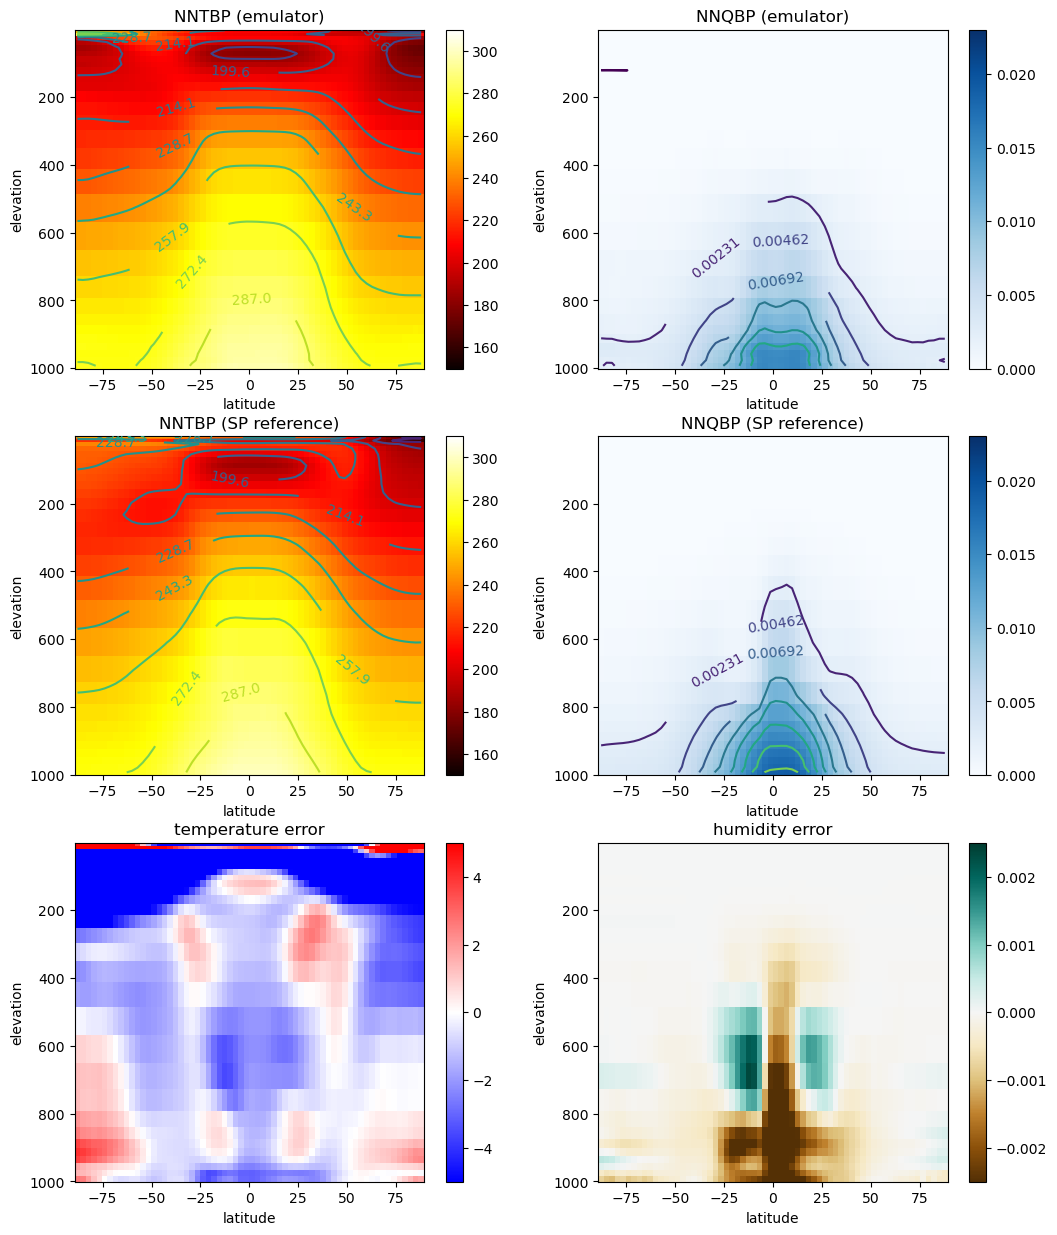

In [311]:
peer(relative_new[2], variant = "original")

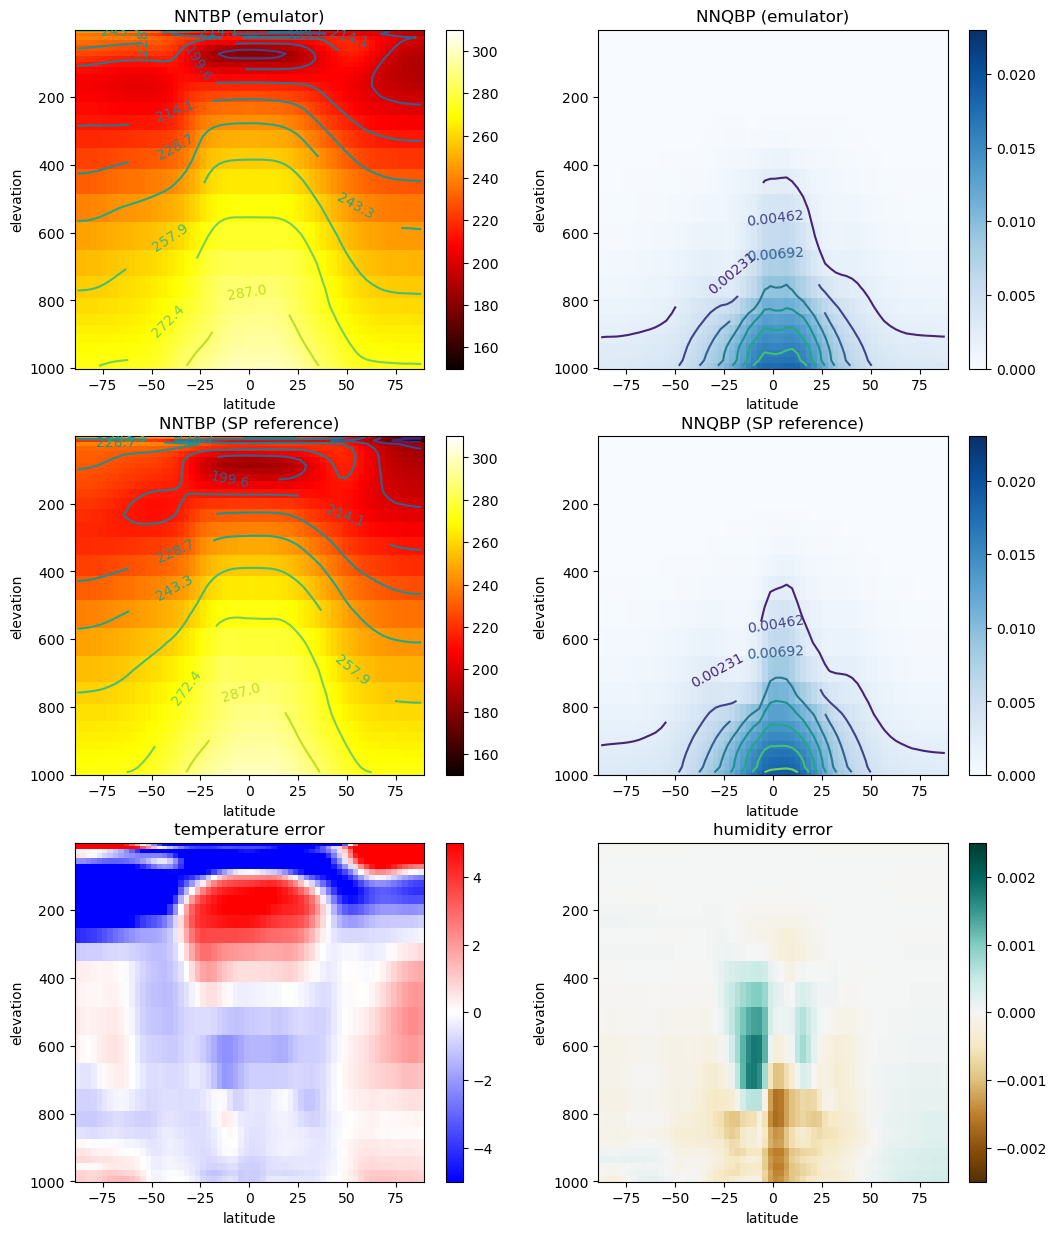

In [315]:
peer(relative_new[3], variant = "original")

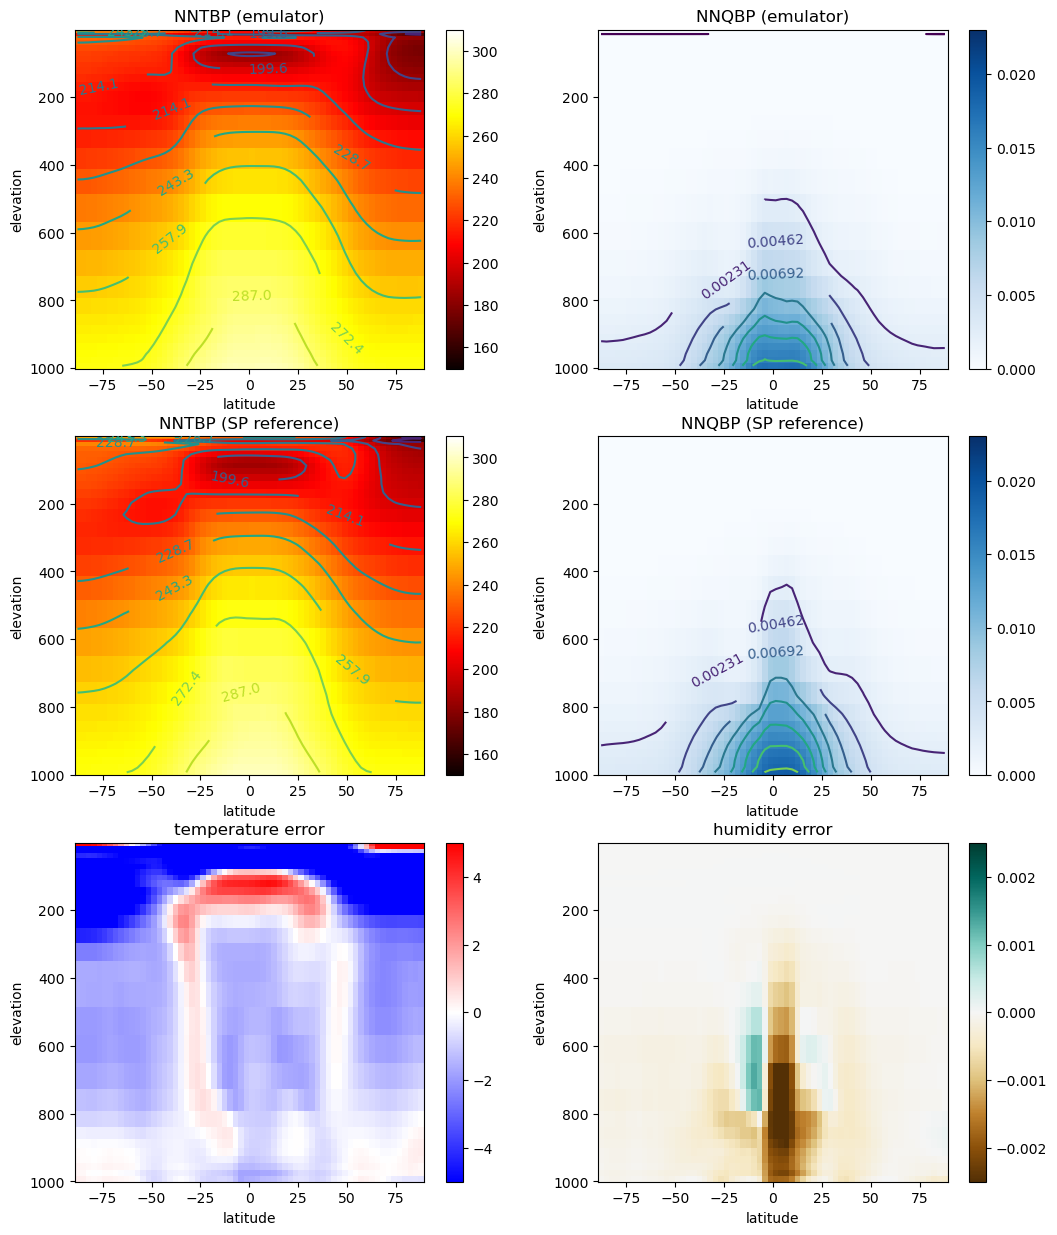

In [319]:
peer(relative_new[4], variant = "original")

### expanded

In [5]:
print(expanded_new[0])

/Users/jerrylin/Desktop/OfflineWork/data/new_runs/expanded/expanded_model_012/


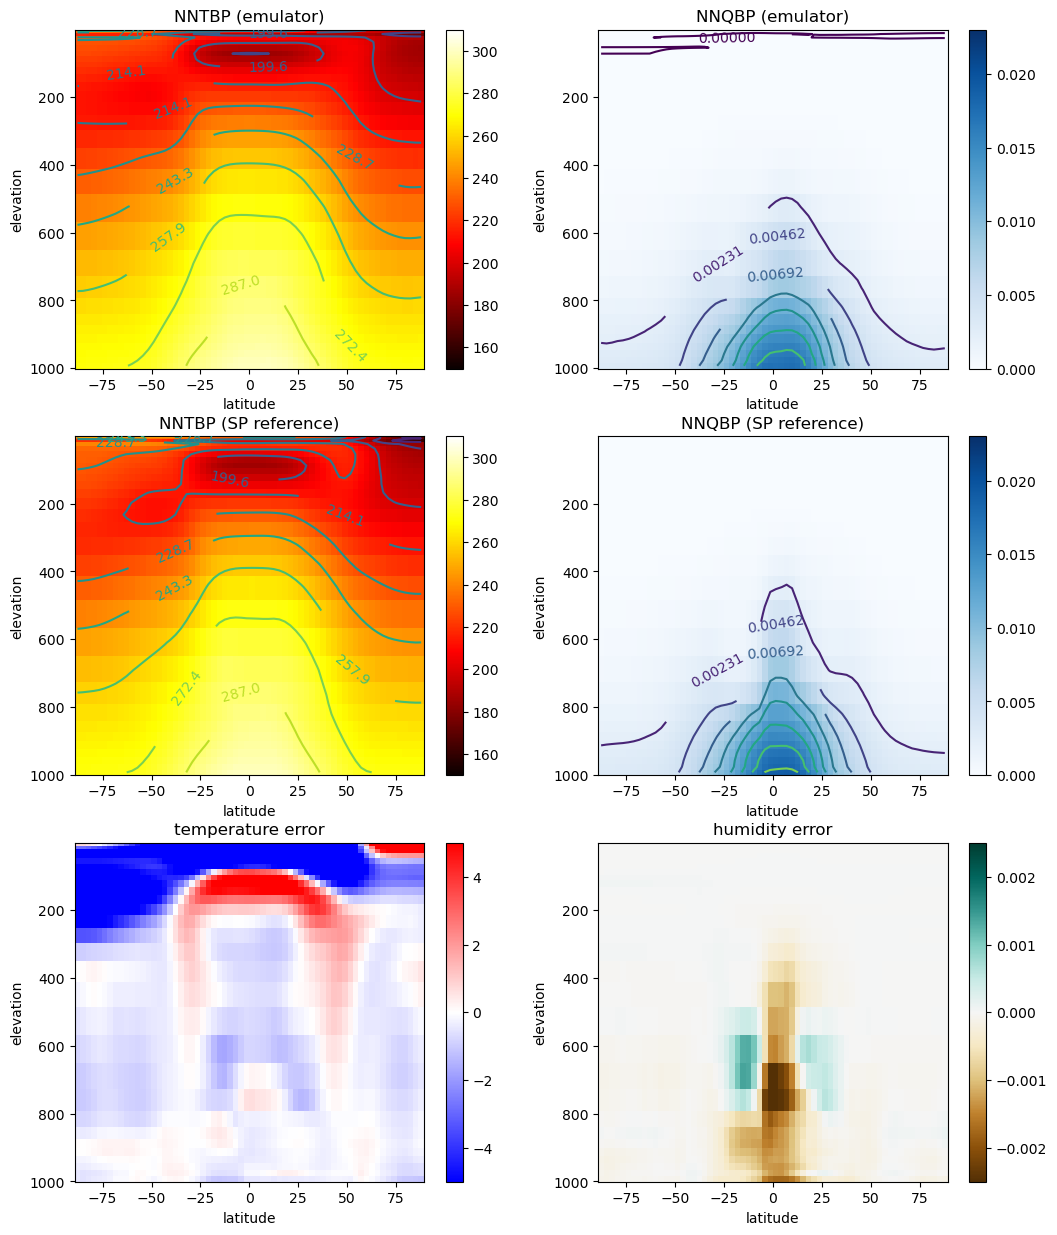

In [323]:
peer(expanded_new[0], variant = "original")

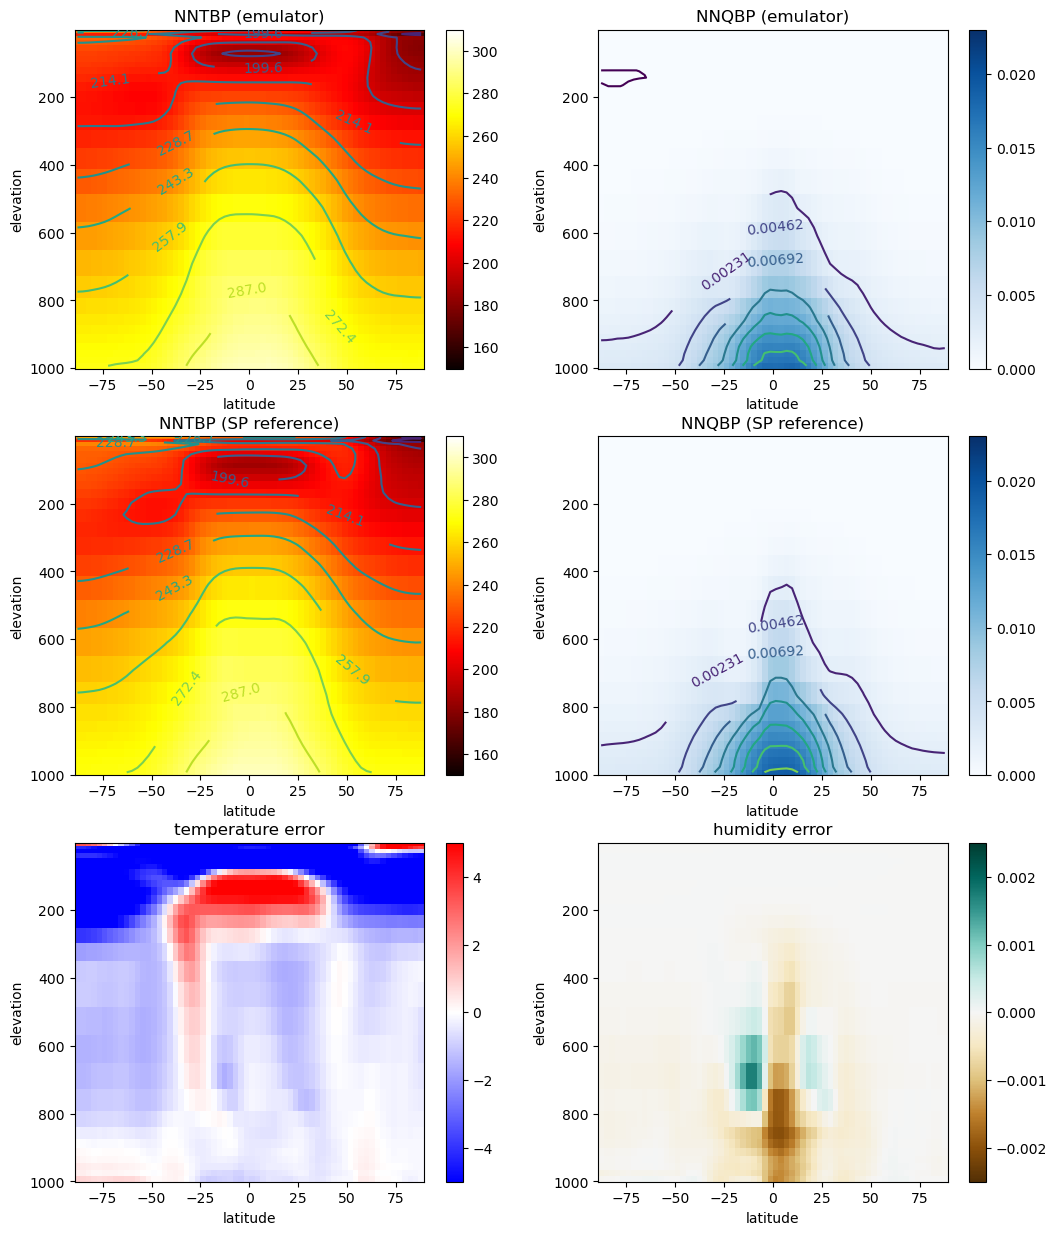

In [327]:
peer(expanded_new[1], variant = "original")

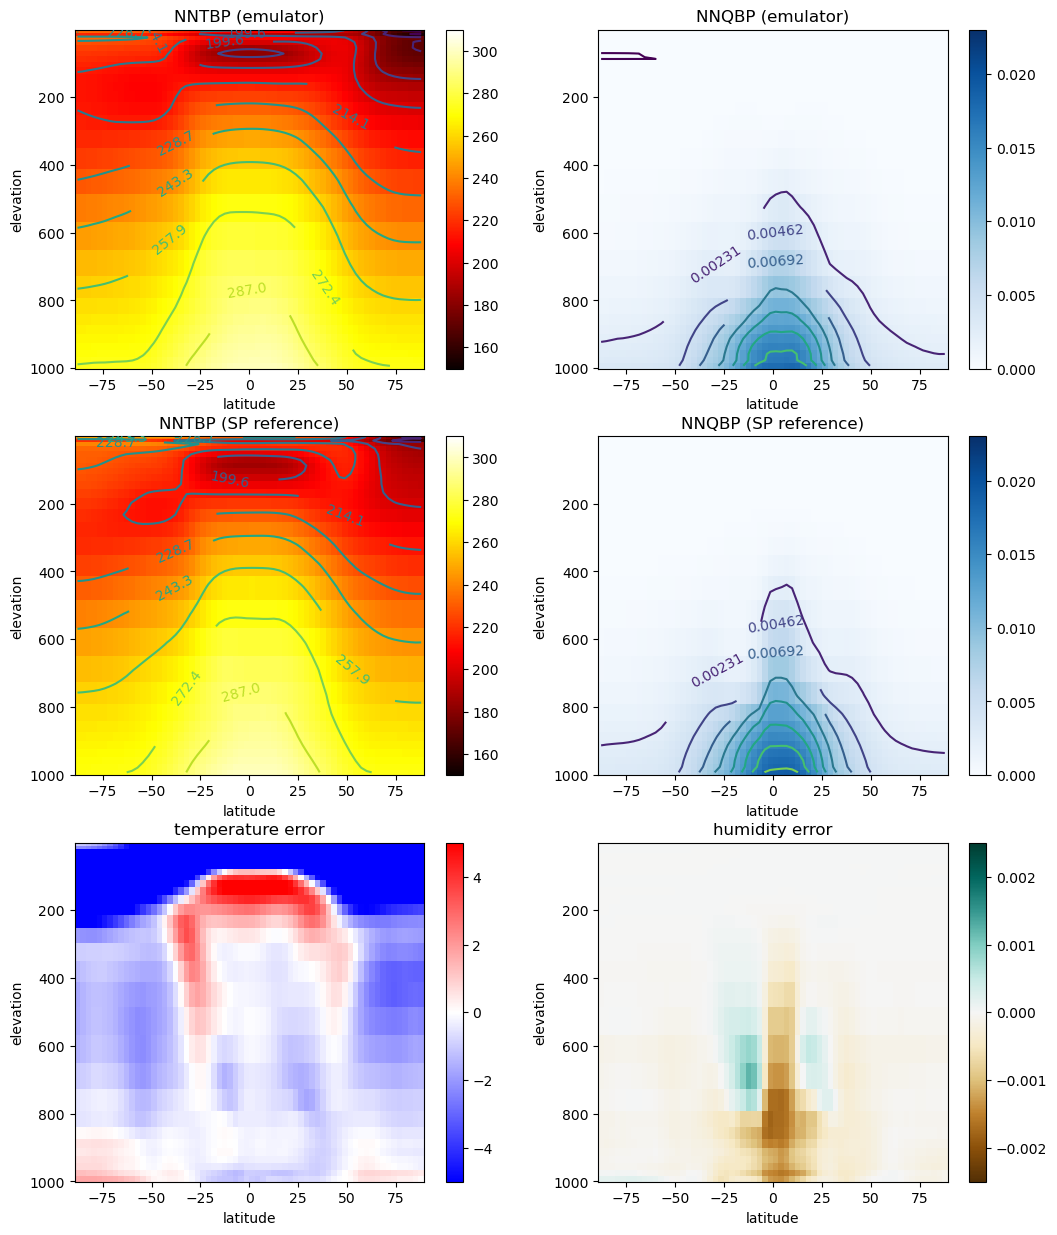

In [331]:
peer(expanded_new[2], variant = "original")

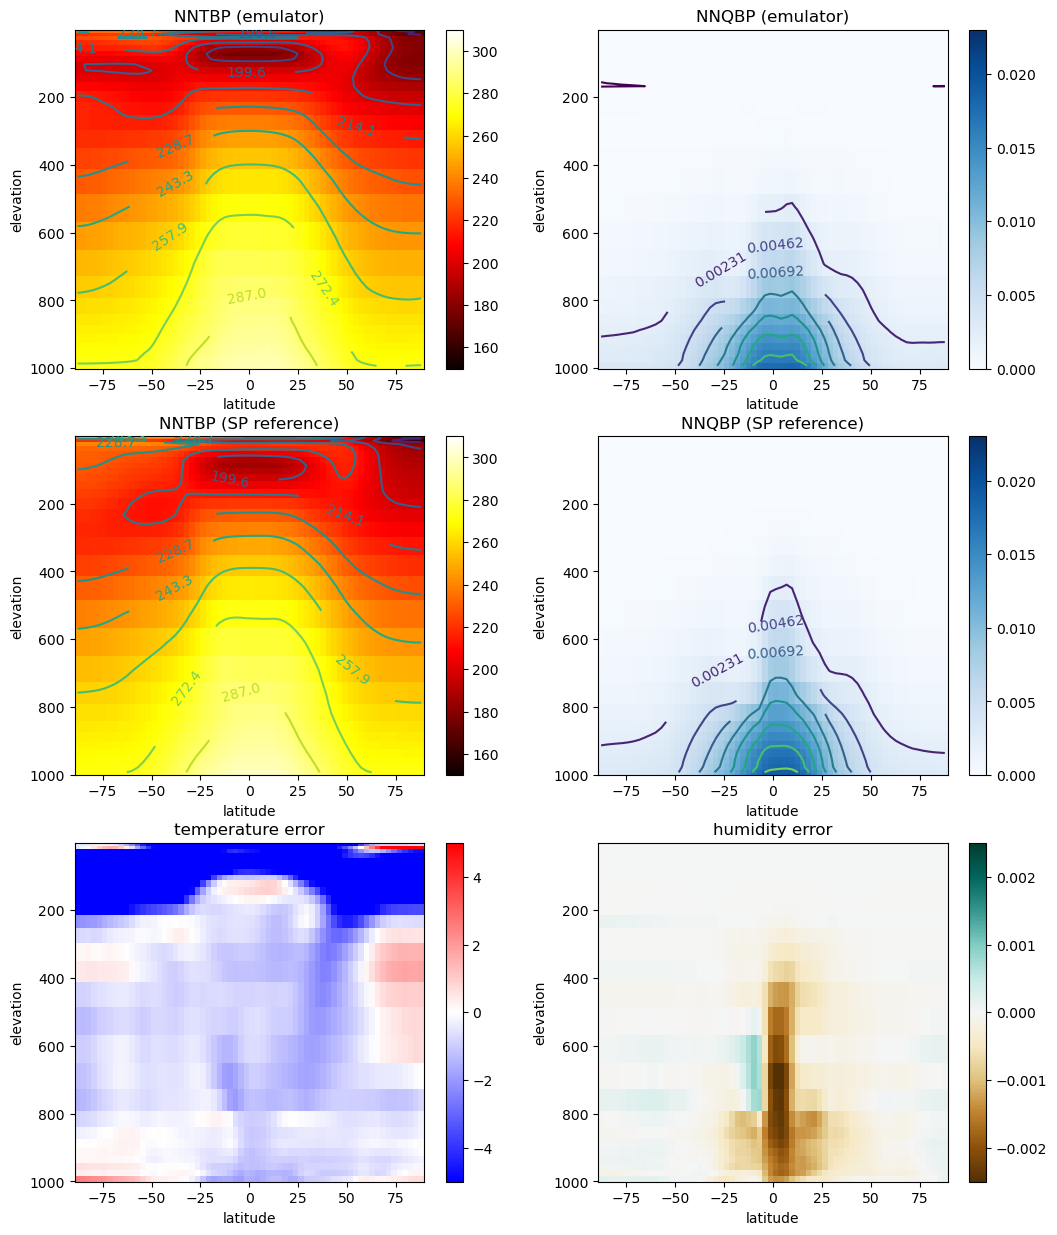

In [335]:
peer(expanded_new[3], variant = "original")

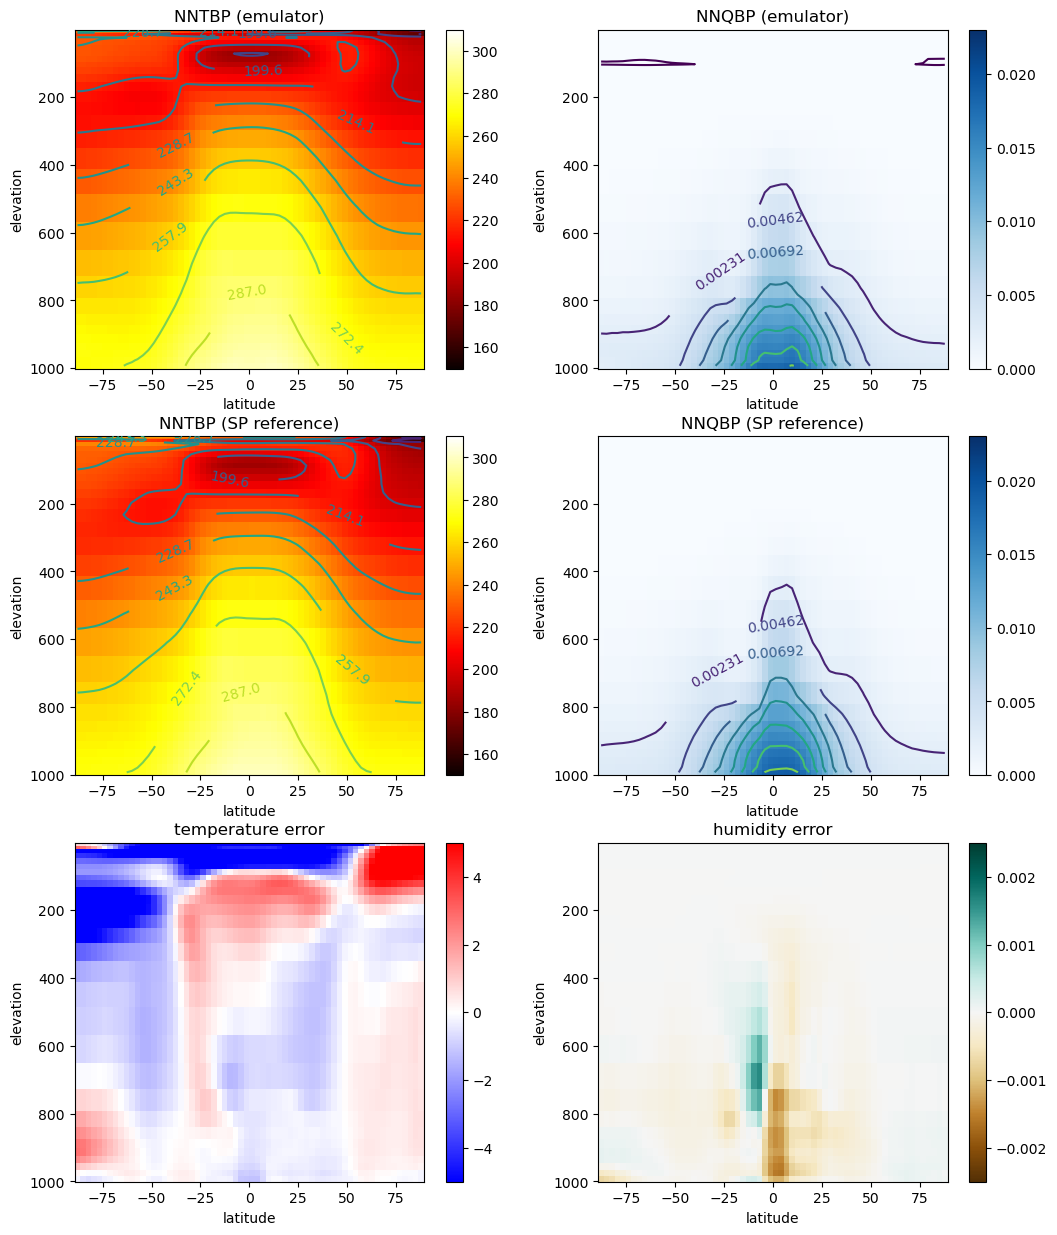

In [339]:
peer(expanded_new[4], variant = "original")

### previous

In [6]:
print(previous_new[0])

/Users/jerrylin/Desktop/OfflineWork/data/new_runs/previous/previousTendencies_model_059/


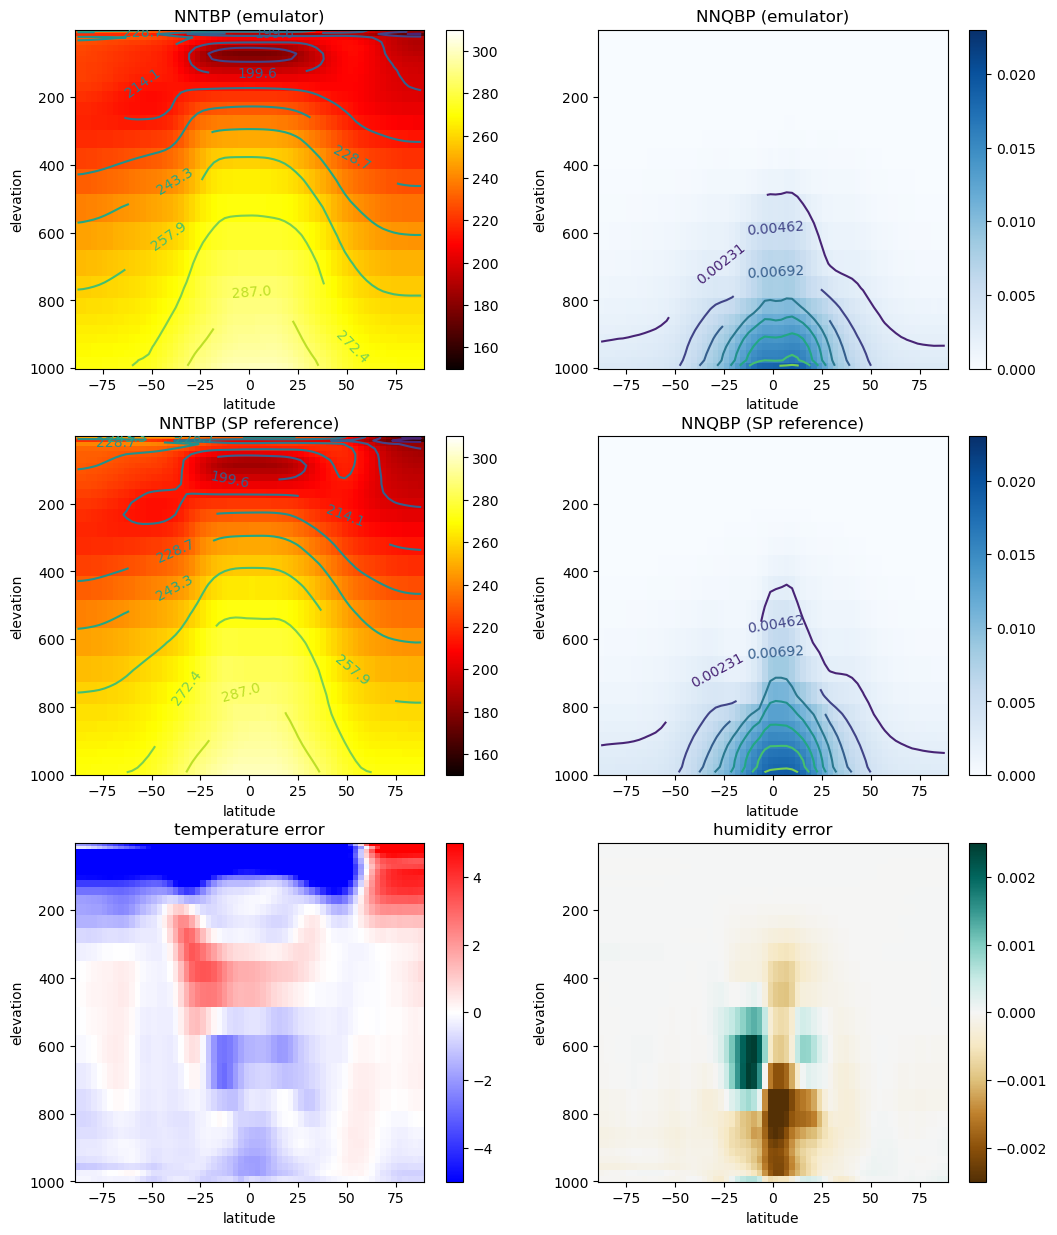

In [343]:
peer(previous_new[0], variant = "original")

In [7]:
print(previous_new[1])

/Users/jerrylin/Desktop/OfflineWork/data/new_runs/previous/previousTendencies_model_072/


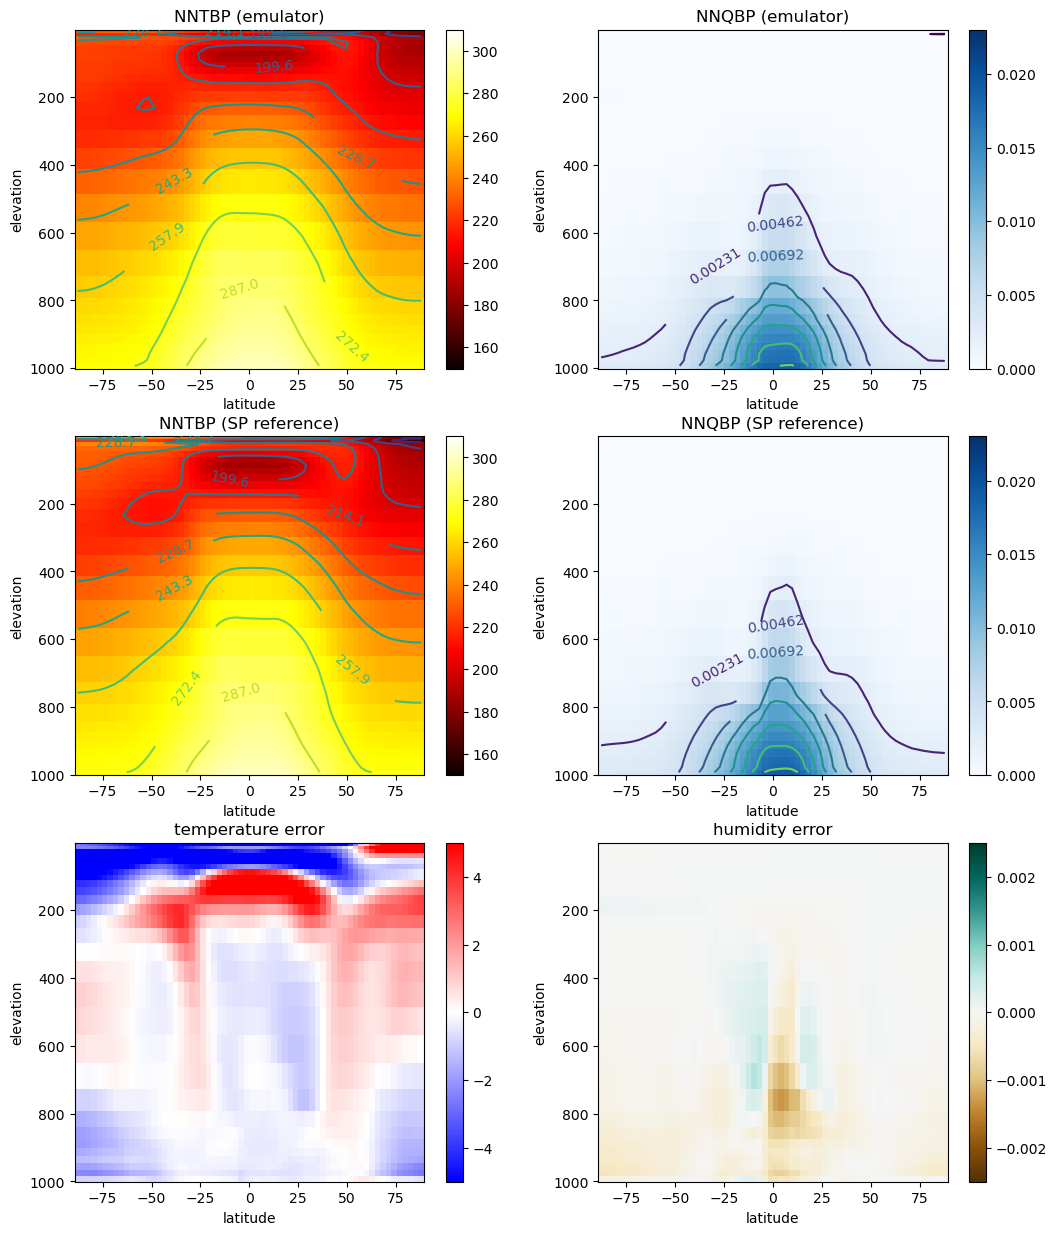

In [347]:
peer(previous_new[1], variant = "original")

In [8]:
print(previous_new[2])

/Users/jerrylin/Desktop/OfflineWork/data/new_runs/previous/previousTendencies_model_112/


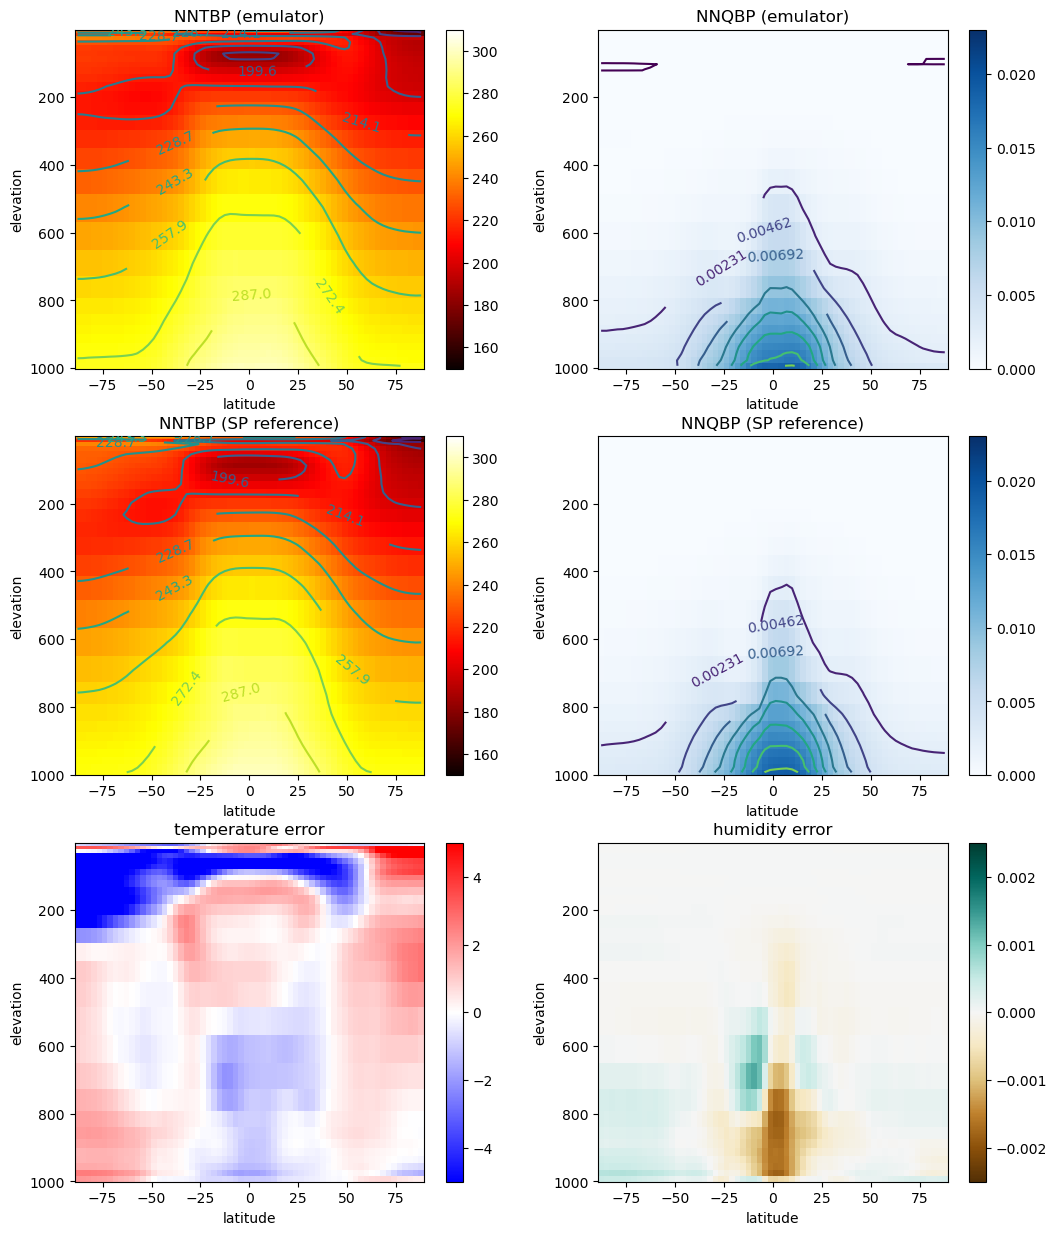

In [351]:
peer(previous_new[2], variant = "original")

In [9]:
print(previous_new[3])

/Users/jerrylin/Desktop/OfflineWork/data/new_runs/previous/previousTendencies_model_173/


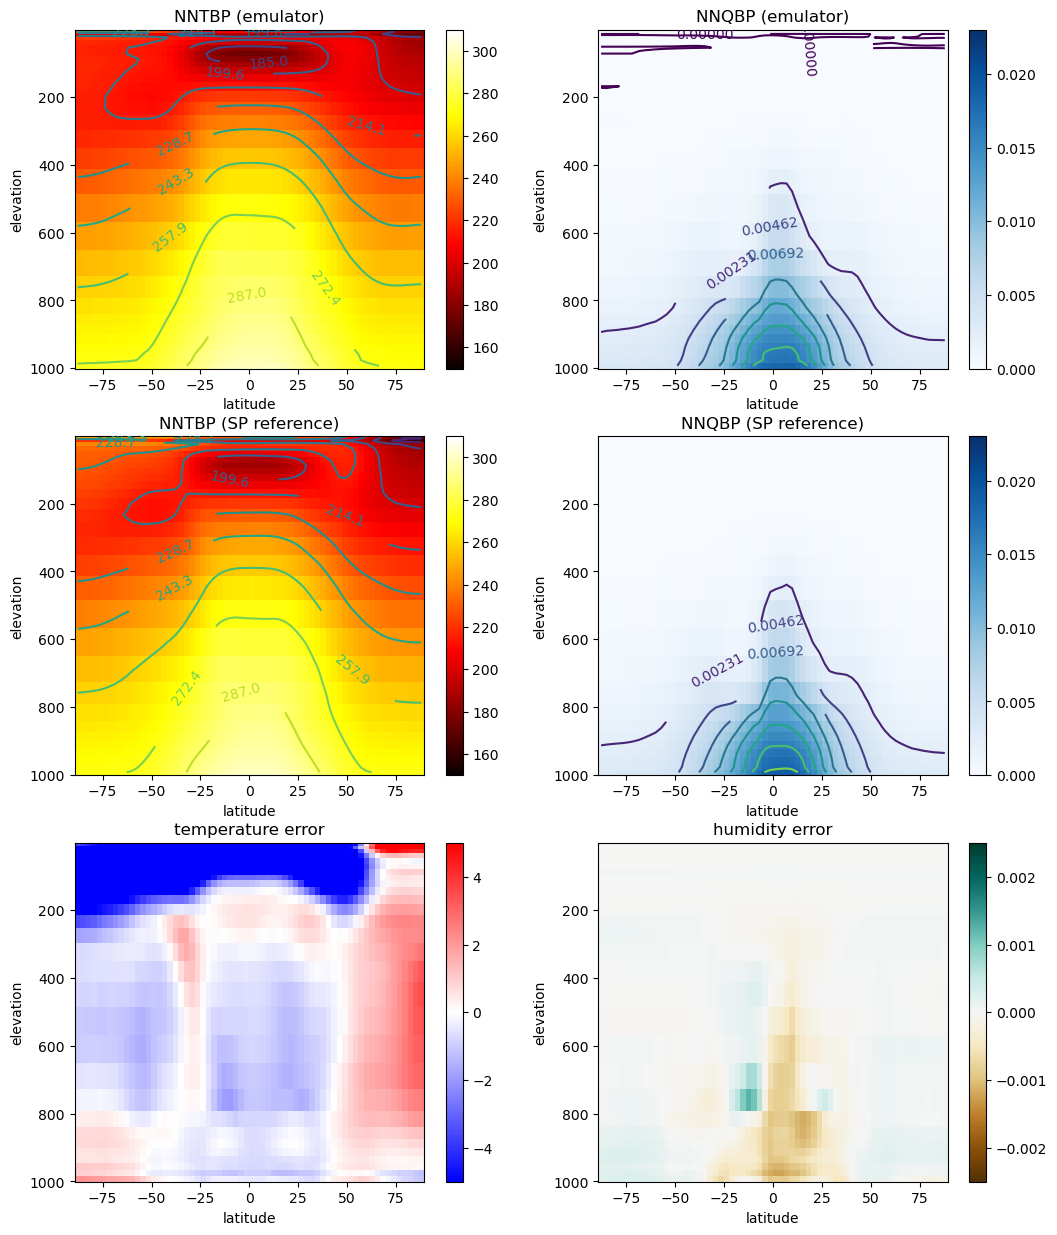

In [355]:
peer(previous_new[3], variant = "original")

In [10]:
print(previous_new[4])

/Users/jerrylin/Desktop/OfflineWork/data/new_runs/previous/previousTendencies_model_193/


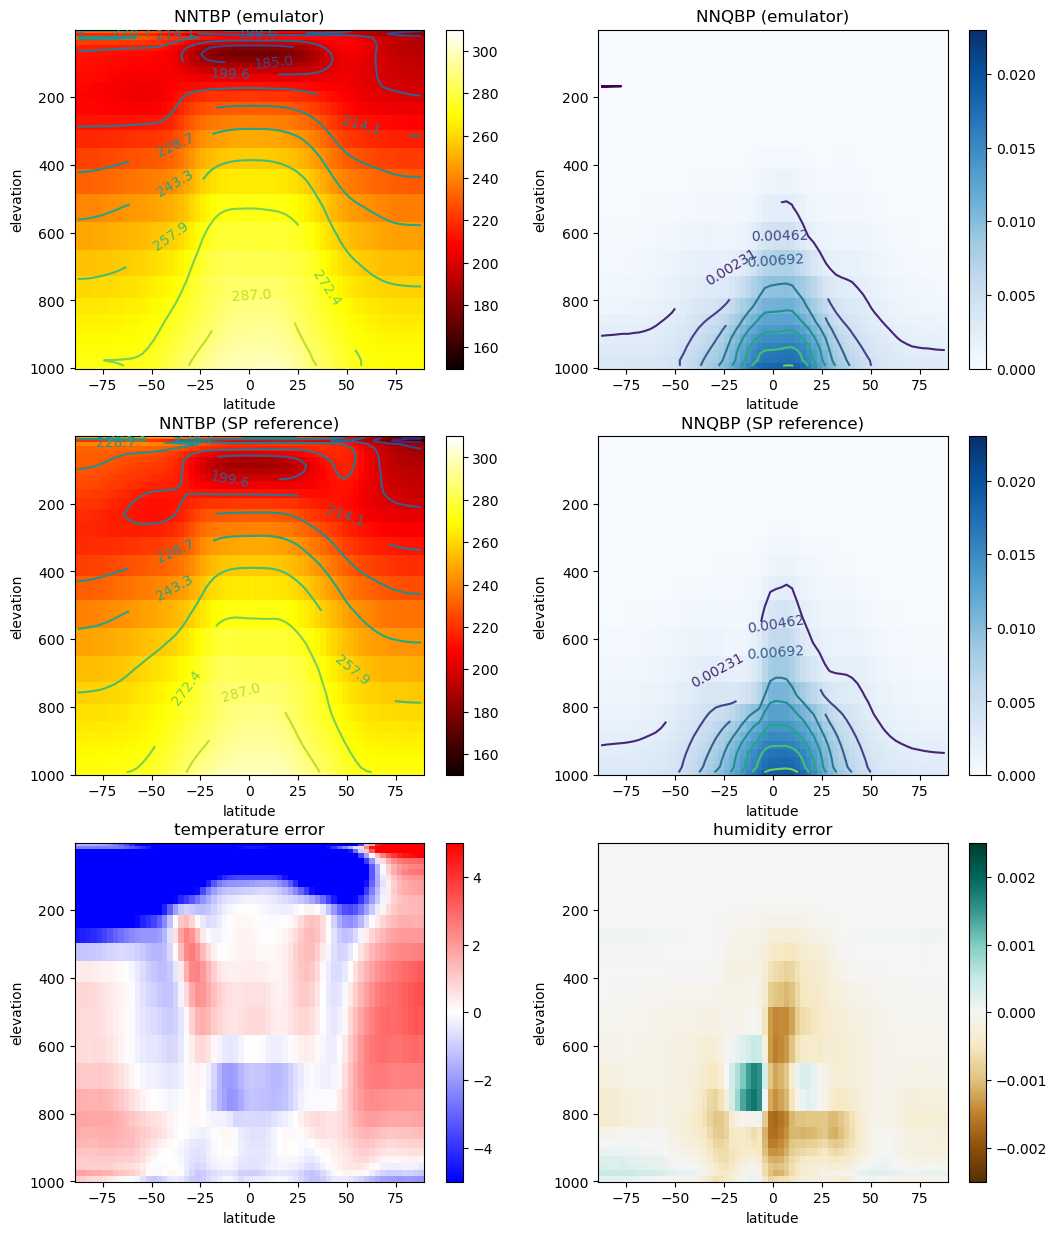

In [359]:
peer(previous_new[4], variant = "original")